# Objective
The objetive of this notebook is to replicate example of section 12.3 https://otexts.com/fpp3/VAR.html.

# Description of the data
The dataset is the change of US consumption and income for every quarter since 1970. 

# Imports, configuration and constants

In [1]:
from os import path
from typing import Optional
from datetime import datetime, timedelta
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
PLOT_TITLE = "US Consumption and Income"
PLOT_X1LABEL = "Consumption"
PLOT_X2LABEL = "Income"

# Functions

In [3]:
def plot_income_consumption(
    df: pd.DataFrame, 
    start_time: str=None, 
    end_time: str=None,
    low_ci: pd.DataFrame=None, 
    up_ci: pd.DataFrame=None
):
    
    df = df.copy()
    
    if start_time is not None:
        df = df.query('date >= @start_time')
    if end_time is not None:
        df = df.query('date <= @end_time')
        
    if low_ci is not None and up_ci is not None:
        low_ci = low_ci[low_ci.date.isin(df.date)]
        up_ci = up_ci[up_ci.date.isin(df.date)]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)#, figsize=(10, 8))

    x = df.date
    y1 = df.consumption
    y2 = df.income

    ax1.plot(x, y1)
    if low_ci is not None and up_ci is not None:
        ax1.fill_between(x, low_ci['low_consumption'], up_ci['upper_consumption'], alpha=0.2)
    ax1.set_title(PLOT_X1LABEL)
    ax1.xaxis.set_tick_params(labelbottom=True)
    ax1.tick_params(axis='x', labelrotation=70)

    ax2.plot(x, y2)
    if low_ci is not None and up_ci is not None:
        ax2.fill_between(x, low_ci['low_income'], up_ci['upper_income'], alpha=0.2)
    ax2.set_title(PLOT_X2LABEL)
    ax2.xaxis.set_tick_params(labelbottom=True)
    ax2.tick_params(axis='x', labelrotation=70)

    fig.text(0.5, 0.04, 'Quarter', ha='center')
    fig.subplots_adjust()
    fig.suptitle(PLOT_TITLE)
    plt.show()

    
def generate_quarters(start_quarter, n):
    quarters = pd.period_range(start_quarter, periods=n+1, freq='Q')[1:]
    return quarters

    
def join_forecast_to_series(
    df: pd.DataFrame,
    df_h: pd.DataFrame,
    df_h_lower: pd.DataFrame,
    df_h_upper: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    variables = ["consumption", "income"]
    
    df_with_h = df.copy()
    df_with_h = pd.concat([df_with_h, df_h])
    df_with_h["date"] = df_with_h.index.start_time
    
    df_with_h_lower = df_with_h.copy()
    df_with_h_lower.loc[df_with_h_lower.index.isin(df.index), variables] = None
    df_with_h_lower[df_with_h_lower.index.isin(df_h_lower.index)] = df_h_lower
    df_with_h_lower = df_with_h_lower.rename(
        columns={
            "consumption": "low_consumption",
            "income": "low_income",
        }
    )

    df_with_h_upper = df_with_h.copy()
    df_with_h_upper.loc[df_with_h_upper.index.isin(df.index), variables] = None
    df_with_h_upper[df_with_h_upper.index.isin(df_h_upper.index)] = df_h_upper
    df_with_h_upper = df_with_h_upper.rename(
        columns={
            "consumption": "upper_consumption",
            "income": "upper_income",
        }
    )
    
    return df_with_h, df_with_h_lower, df_with_h_upper

# Load data

In [4]:
data_dir_path = "../data/"
us_change_path = path.join(data_dir_path, "us_change.rda")

result = pyreadr.read_r(us_change_path) # also works for Rds, rda

df = result['us_change']

df.columns = df.columns.str.lower()

# Prepare data
Filter the data as done in the book.

In [5]:
df = df[["quarter", "consumption", "income"]].copy()

# From the uschange.R code we can see that the first day is 19700101
dates = []
for quarter in df["quarter"]:
    days = int(quarter)  # convert quarters to days
    date = datetime(1970, 1, 1) + timedelta(days=quarter)
    dates.append(date)

df["quarter"] = pd.Series(dates).dt.to_period('Q').copy()
df["date"] = dates

In [6]:
df

,quarter,consumption,income,date
0,1970Q1,0.618566,1.044801,1970-01-01
1,1970Q2,0.451984,1.225647,1970-04-01
2,1970Q3,0.872872,1.585154,1970-07-01
3,1970Q4,-0.271848,-0.239545,1970-10-01
4,1971Q1,1.901345,1.975925,1971-01-01
...,...,...,...,...
193,2018Q2,0.983112,0.661825,2018-04-01
194,2018Q3,0.853181,0.806271,2018-07-01
195,2018Q4,0.356512,0.695142,2018-10-01
196,2019Q1,0.282885,1.100753,2019-01-01


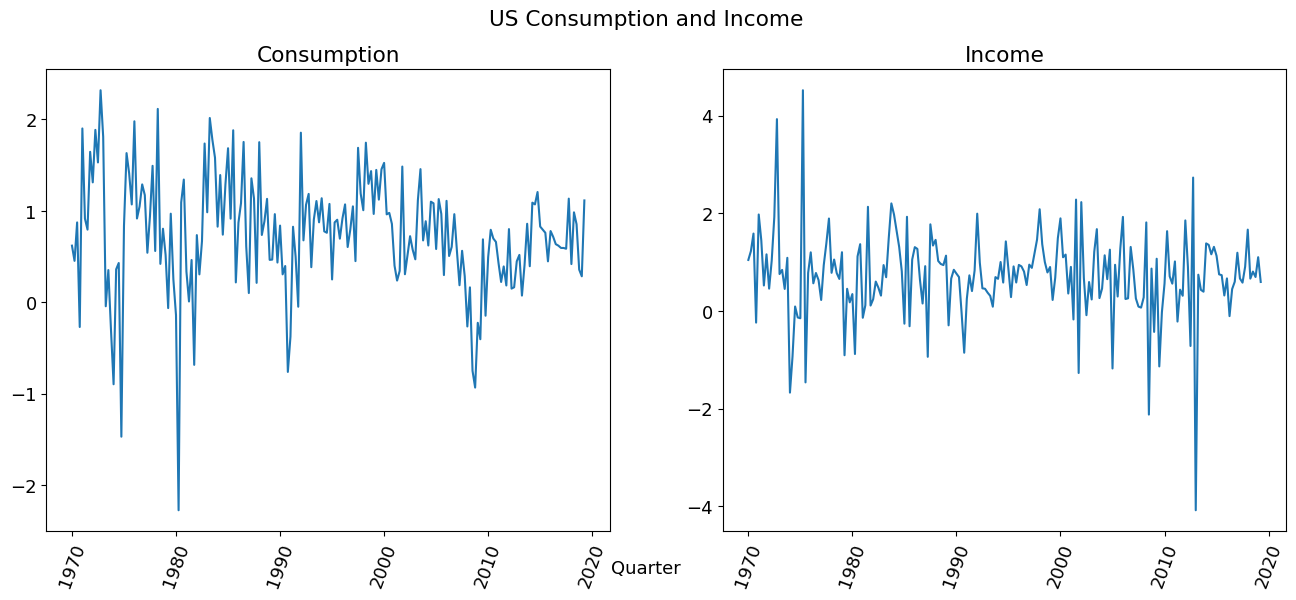

In [7]:
plot_income_consumption(df)

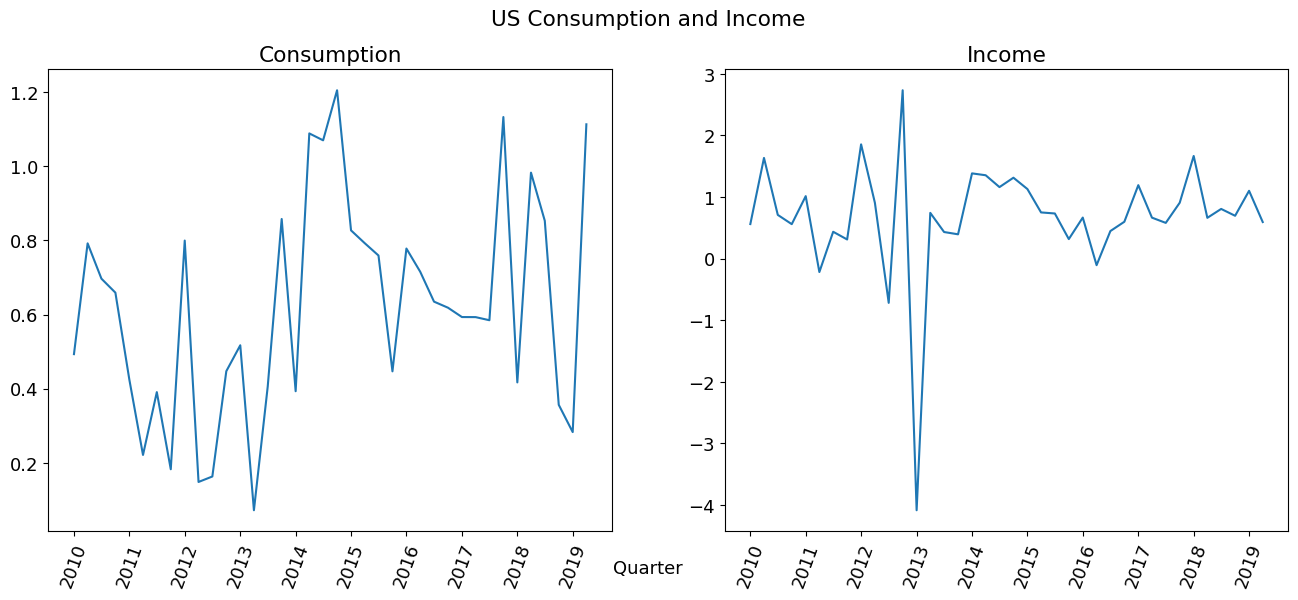

In [8]:
plot_income_consumption(df, start_time='2010')

# Forecasting

Note that this data is already differenciated which has caused the time series to be stationary. This condition is needed for VAR models.

In [9]:
df.index = df.quarter
df = df[["consumption", "income"]]

In [10]:
model = VAR(df)

In the book the default information criterion is AICC. This model does not include it. Thus, we use the AIC.

In [23]:
help(model.fit)

Help on method fit in module statsmodels.tsa.vector_ar.var_model:

fit(maxlags: 'int | None' = None, method='ols', ic=None, trend='c', verbose=False) method of statsmodels.tsa.vector_ar.var_model.VAR instance
    Fit the VAR model
    
    Parameters
    ----------
    maxlags : {int, None}, default None
        Maximum number of lags to check for order selection, defaults to
        12 * (nobs/100.)**(1./4), see select_order function
    method : {'ols'}
        Estimation method to use
    ic : {'aic', 'fpe', 'hqic', 'bic', None}
        Information criterion to use for VAR order selection.
        aic : Akaike
        fpe : Final prediction error
        hqic : Hannan-Quinn
        bic : Bayesian a.k.a. Schwarz
    verbose : bool, default False
        Print order selection output to the screen
    trend : str {"c", "ct", "ctt", "n"}
        "c" - add constant
        "ct" - constant and trend
        "ctt" - constant, linear and quadratic trend
        "n" - co constant, no trend
 

In [24]:
results_aic = model.fit(maxlags=5, ic='aic')
results_bic = model.fit(maxlags=5, ic='bic')

We obtain the same results as in the book and, as mentioned there, the BIC penalizes more the number of parameters. The book does not include the coefficients so we can't compare them. However, even if the log likelihood is the same as the ones in the book, the BIC and AIC values are different (I still don't know why). We select the model with the 5 lags as it has better information criteria metrics.

In [12]:
results_aic.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     20:48:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.21205
Nobs:                     193.000    HQIC:                  -1.43335
Log likelihood:          -372.858    FPE:                   0.205212
AIC:                     -1.58396    Det(Omega_mle):        0.183678
--------------------------------------------------------------------
Results for equation consumption
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.349635         0.086981            4.020           0.000
L1.consumption         0.186358         0.077075            2.418           0.016
L1.income              0.111834         0.053490  

In [13]:
results_bic.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     20:48:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.37343
Nobs:                     197.000    HQIC:                  -1.43295
Log likelihood:          -407.929    FPE:                   0.229140
AIC:                     -1.47343    Det(Omega_mle):        0.222318
--------------------------------------------------------------------
Results for equation consumption
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.464295         0.067666            6.862           0.000
L1.consumption         0.265297         0.072674            3.651           0.000
L1.income              0.112969         0.051443  

The book shows its two acf plots for its two models. I don't understand why this library shows four plots.

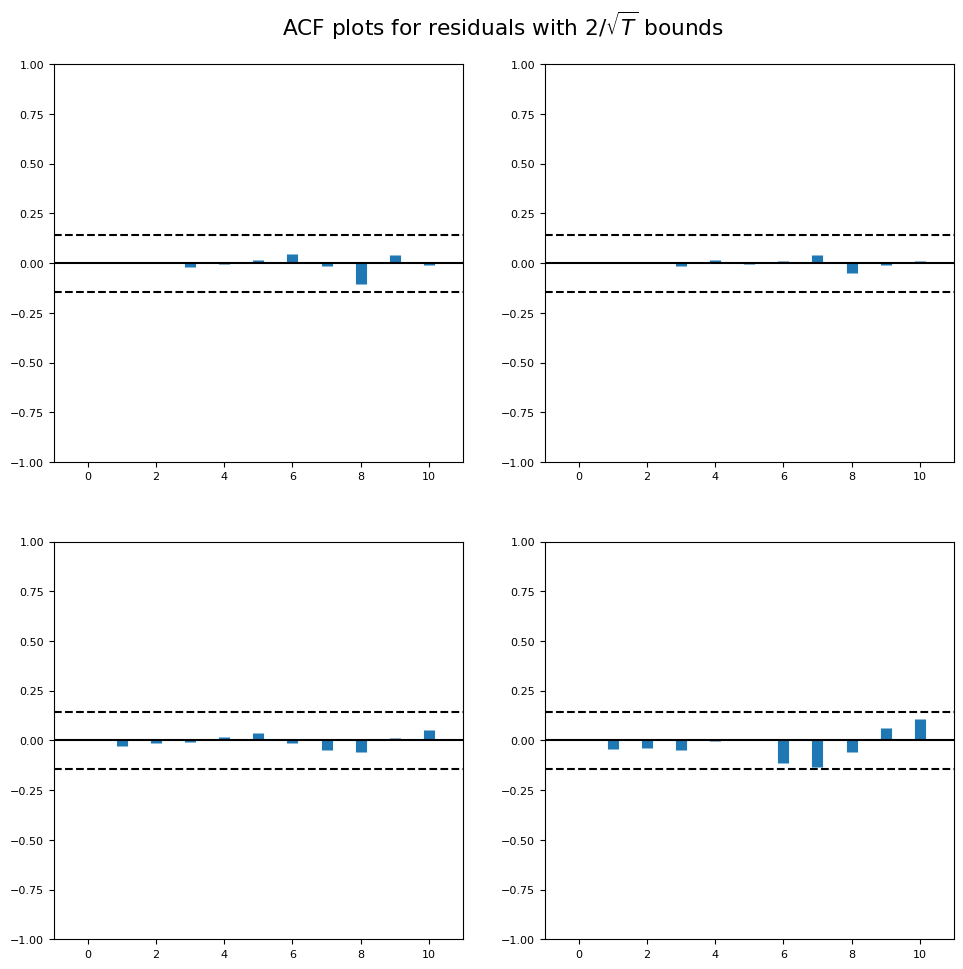

In [14]:
results_aic.plot_acorr();

We forecast the same amount of steps as in the book.

In [15]:
lag_order = results_aic.k_ar
steps = 12
pred = results_aic.forecast_interval(df.values[-lag_order:], steps)

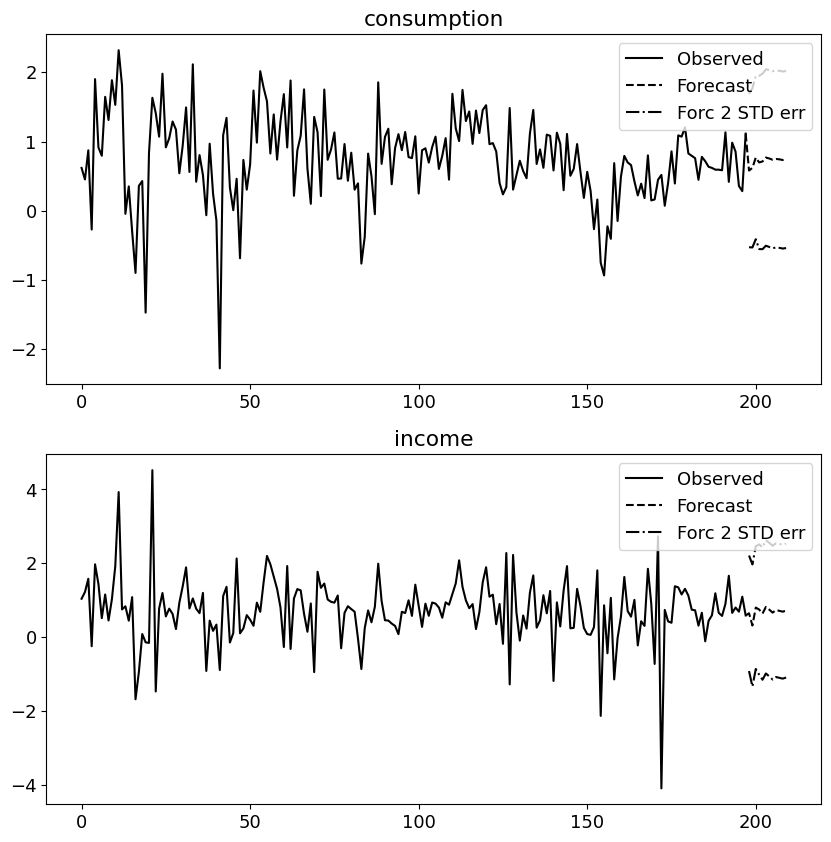

In [16]:
results_aic.plot_forecast(steps);

In [18]:
quarters = generate_quarters(df.index[-1], steps)
dates = quarters.start_time

df_h = pd.DataFrame(
    {
        "consumption": pred[0][:,0],
        "income": pred[0][:,1],
        "date":dates
    }, 
    index=quarters
)

df_h_lower = pd.DataFrame(
    {
        "low_consumption": pred[1][:,0],
        "low_income": pred[1][:,1],
        "date":dates
    }, 
    index=quarters
)

df_h_upper = pd.DataFrame(
    {
        "upper_consumption": pred[2][:,0],
        "upper_income": pred[2][:,1],
        "date":dates
    }, 
    index=quarters
)

Plotting the forecasts.

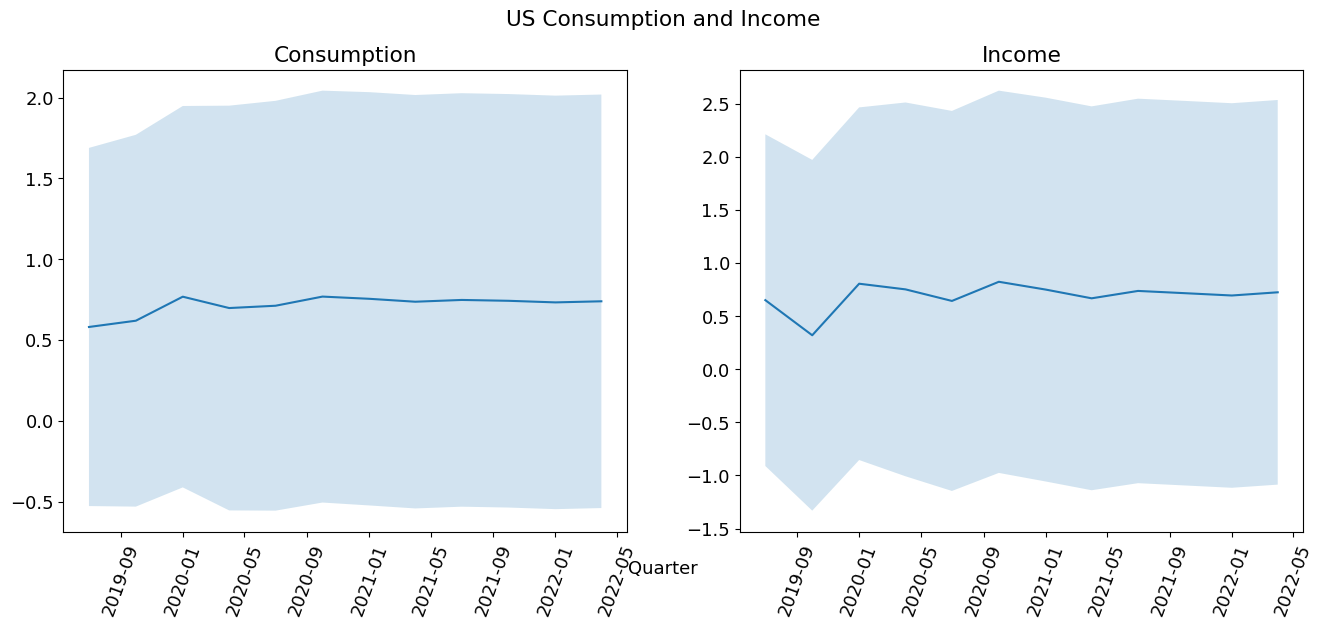

In [19]:
plot_income_consumption(
    df_h, 
    low_ci=df_h_lower, 
    up_ci=df_h_upper,
)

Joining the forecasts with the series.

In [20]:
df_with_h, df_with_h_lower, df_with_h_upper = join_forecast_to_series(
    df,
    df_h,
    df_h_lower,
    df_h_upper,
)

Plotting forecasts and the series.

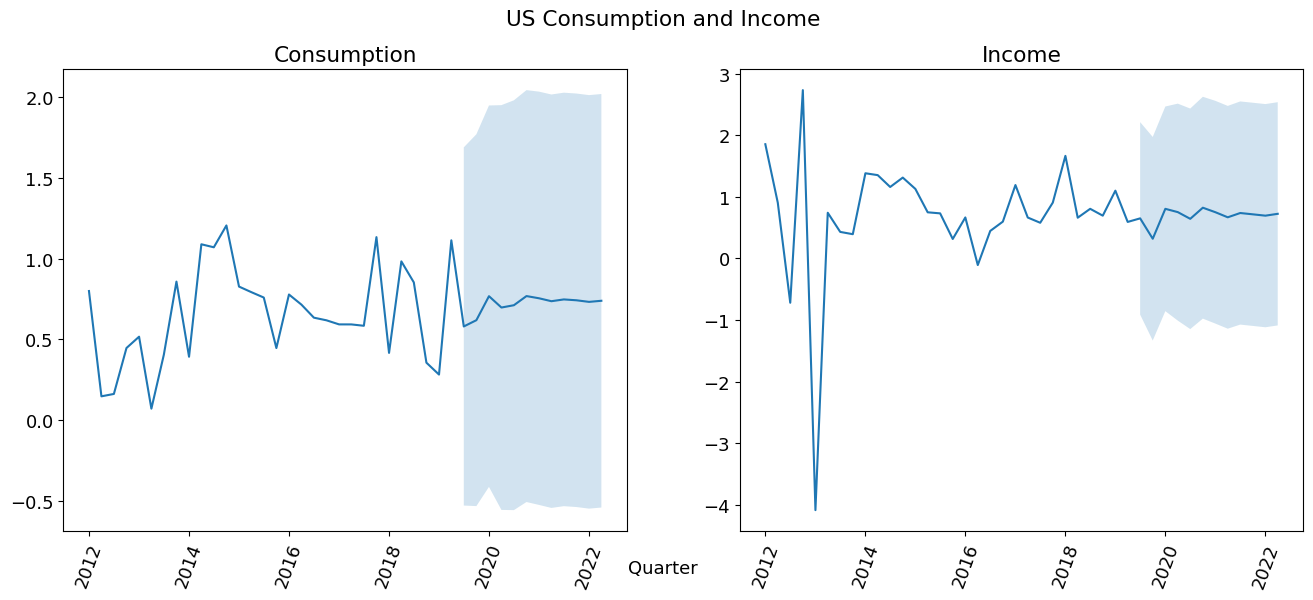

In [21]:
plot_income_consumption(
    df_with_h, 
    start_time="2012",
    low_ci=df_with_h_lower, 
    up_ci=df_with_h_upper,
)